# Training an RL agent with Keras-RL2 Using a GEM Environment

This notebook serves as an educational introduction to the usage of Keras-RL2 using a GEM environment. Goal of this notebook is to give an understanding of what Keras-RL2 is and how to use it to train and evaluate a Reinforcement Learning agent which is able to solve a current control problem within the GEM toolbox.

## 1. Installation

Before you can start you need to make sure that you have installed both, gym-electric-motor and Keras-RL2. You can install both easily using pip:

- ```pip install gym-electric-motor```
- ```pip install keras-rl2```

Alternatively, you can install them and their latest developer version directly from GitHub (recommended) :

- https://github.com/upb-lea/gym-electric-motor
- https://github.com/wau/keras-rl2

For this notebook, the following cell will do the job:

In [1]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git git+https://github.com/wau/keras-rl2.git

## 2. Setting up a GEM Environment

The basic idea behind reinforcement learning is to create a so-called agent, that should learn by itself to solve a specified task in a given environment. 
This environment gives the agent feedback on its actions and reinforces the targeted behavior.
In this notebook, the task is to train a controller for the current control of a *permanent magnet synchronous motor* (*PMSM*).
 
In the following, the used GEM-environment is briefly presented, but this notebook does not focus directly on the detailed usage of GEM. If you are new to the used environment and interested in finding out what it does and how to use it, you should take a look at the [GEM cookbook](https://colab.research.google.com/github/upb-lea/gym-electric-motor/blob/master/examples/example_notebooks/GEM_cookbook.ipynb).

To save some space in this notebook, there is a function defined in an external python file called **getting_environment.py**. If you want to know how the environment's parameters are defined you can take a look at that file. By simply calling the **get_env()** function from the external file, you can set up an environment for a *PMSM* with discrete inputs.

The basic idea of the control setup from the GEM-environment is displayed in the following figure. 

![](../../docs/plots/SCML_Overview.png)

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the *PMSM*: $i_{sq}$ and $i_{sd}$

In the continuous case, the agent's action equals a duty cycle which will be modulated into a corresponding voltage. 

In the discrete case, the agent's actions denote switching states of the converter at the given instant. Here, only a discrete amount of options are available. In this notebook, for the PMSM the *discrete B6 bridge converter* with six switches is utilized per default. This converter provides a total of eight possible actions.

![](../../docs/plots/B6.svg)

The motor schematic is the following:


![](../../docs/plots/ESBdq.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

<!-- $\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
 -->

   $ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
    $\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
   $\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>

The target for the agent is now to learn to control the currents. For this, a reference generator produces a trajectory that the agent has to follow. 
Therefore, it has to learn a function (policy) from given states, references and rewards to appropriate actions.

For a deeper understanding of the used models behind the environment see the [documentation](https://upb-lea.github.io/gym-electric-motor/).
Comprehensive learning material to RL is also [freely available](https://github.com/upb-lea/reinforcement_learning_course_materials).


In [2]:
import numpy as np
from pathlib import Path
import gym_electric_motor as gem
from gym_electric_motor.reference_generators import \
    MultipleReferenceGenerator,\
    WienerProcessReferenceGenerator
from gym_electric_motor.visualization import MotorDashboard
from gym.spaces import Discrete, Box
from gym.wrappers import FlattenObservation, TimeLimit
from gym import ObservationWrapper

/home/wilhelmk/tools/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation. Serves
    the purpose to improve the agent's learning speed.
    
    It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
    to have the angles -pi and pi close to each other numerically without losing
    any information on the angle.
    
    Additionally, this wrapper adds a new observation i_sd**2 + i_sq**2. This should
    help the agent to easier detect incoming limit violations.
    """

    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation

In [4]:
# define motor arguments
motor_parameter = dict(p=3,  # [p] = 1, nb of pole pairs
                       r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
                       l_d=0.37e-3,  # [l_d] = H, d-axis inductance
                       l_q=1.2e-3,  # [l_q] = H, q-axis inductance
                       psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
                       )
# supply voltage
u_sup = 350
# nominal and absolute state limitations
nominal_values=dict(omega=4000*2*np.pi/60,
                    i=230,
                    u=u_sup
                    )
limit_values=dict(omega=4000*2*np.pi/60,
                    i=1.5*230,
                    u=u_sup
                    )
# defining reference-generators
q_generator = WienerProcessReferenceGenerator(reference_state='i_sq')
d_generator = WienerProcessReferenceGenerator(reference_state='i_sd')
rg = MultipleReferenceGenerator([q_generator, d_generator])
# defining sampling interval
tau = 1e-5
# defining maximal episode steps
max_eps_steps = 10000


motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1)


# creating gem environment
env = gem.make(  # define a PMSM with discrete action space
    "PMSMDisc-v1",
    # visualize the results
    visualization=MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True),
    # parameterize the PMSM and update limitations
    motor_parameter=motor_parameter,
    limit_values=limit_values, nominal_values=nominal_values,
    # define the random initialisation for load and motor
    load='ConstSpeedLoad',
    load_initializer={'random_init': 'uniform', },
    motor_initializer=motor_initializer,
    reward_function=reward_function,

    # define the duration of one sampling step
    tau=tau, u_sup=u_sup,
    # turn off terminations via limit violation, parameterize the rew-fct
    reference_generator=rg, ode_solver='euler',
)

# remove one action from the action space to help the agent speed up its training
# this can be done as both switchting states (1,1,1) and (-1,-1,-1) - which are encoded
# by action 0 and 7 - both lead to the same zero voltage vector in alpha/beta-coordinates
env.action_space = Discrete(7)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(FeatureWrapper(FlattenObservation(env), 
                               eps_idx, i_sd_idx, i_sq_idx),
                max_eps_steps)

## 3. Train an Agent with Keras-RL2

[Keras-RL2](https://github.com/wau/keras-rl2) is a widely used Python library for reinforcement learning. It compiles a collection of Reinforcement Learning algorithm implementations.
Most of the algorithms and their extensions are readily available and are quite stable. The ease of adopting to various environments adds to its popularity.
For currently available RL algorithms see their [documentation](https://keras-rl.readthedocs.io/en/latest/agents/overview/)

### 3.1 Imports
The environment in this control problem poses a discrete action space. Therefore, the [Deep Q-Network (DQN)](https://arxiv.org/abs/1312.5602) is a suitable agent.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

### 3.2 Parameters and Instantiation

For the DQN algorithm, a set of parameters has to be pre-defined.
In particular, a multilayer perceptron (MLP) is used as function approximator within the DQN algorithm.
Note: Although there are 8 possible actions, we ignore the last action as the voltage applied on the motor there is the same as for the first action. This effectively reduces the feature space that is to be explored and benefits training.

In [6]:
# Training parameters.
time_limit = True
buffer_size = 200000  # observation history size
batch_size = 25  # mini batch size sampled from history at each update step
nb_actions = env.action_space.n
window_length = 1

# construct a MLP
model = Sequential()
model.add(Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(Dense(64, activation='relu'))  # hidden layer 1
model.add(Dense(64, activation='relu'))  # hidden layer 2
model.add(Dense(nb_actions, activation='linear'))  # output layer

# keras-rl2 objects
memory = SequentialMemory(limit=200000, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(eps=0.2), 'eps', 1, 0.05, 0, 50000)

### 3.3 Training

Once you've setup the environment and defined your parameters starting the training is nothing more than a one-liner. For each algorithm all you have to do is call its ```fit()``` function.

The advantage of keras-RL2 is that you can see all the important parameters and their values during training phase to get an intution of learning.
Hence, there is no need of additional callbacks.

In [7]:
dqn = DQNAgent(
    model=model,
    policy=policy,
    nb_actions=nb_actions,
    memory=memory,
    gamma=0.99,
    batch_size=25,
    train_interval=1,
    memory_interval=1,
    target_model_update=1000,
    nb_steps_warmup=10000,
    enable_double_dqn=True
)

dqn.compile(Adam(lr=1e-4),
            metrics=['mse']
            )

Training for 100000 steps ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


<IPython.core.display.Javascript object>


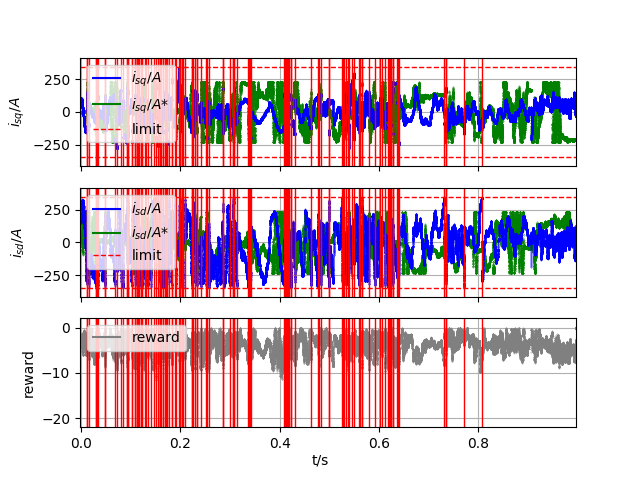

  1071/100000: episode: 1, duration: 1.541s, episode steps: 1071, steps per second: 695, episode reward: -5681.995, mean reward: -5.305 [-2000.000, -0.581], mean action: 2.986 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
  1224/100000: episode: 2, duration: 0.115s, episode steps: 153, steps per second: 1336, episode reward: -2484.636, mean reward: -16.239 [-2000.000, -0.618], mean action: 2.817 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
  1509/100000: episode: 3, duration: 0.234s, episode steps: 285, steps per second: 1216, episode reward: -3035.728, mean reward: -10.652 [-2000.000, -1.583], mean action: 3.025 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
  2889/100000: episode: 4, duration: 1.330s, episode steps: 1380, steps per second: 1037, episode reward: -7204.951, mean reward: -5.221 [-2000.000, -0.148], mean action: 2.933 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
  2966/100000: episode: 5, duration: 0.065s, epis

 14123/100000: episode: 34, duration: 4.165s, episode steps: 665, steps per second: 160, episode reward: -3890.711, mean reward: -5.851 [-2000.000, -0.288], mean action: 3.495 [0.000, 6.000],  loss: 3697.737693, mse: 1100.509215, mean_q: -5.971015, mean_eps: 0.737990
 14598/100000: episode: 35, duration: 2.909s, episode steps: 475, steps per second: 163, episode reward: -4109.260, mean reward: -8.651 [-2000.000, -0.232], mean action: 3.701 [0.000, 6.000],  loss: 5158.581902, mse: 1549.870762, mean_q: -8.167042, mean_eps: 0.727160
 15008/100000: episode: 36, duration: 2.482s, episode steps: 410, steps per second: 165, episode reward: -3724.993, mean reward: -9.085 [-2000.000, -1.292], mean action: 3.795 [0.000, 6.000],  loss: 5190.577190, mse: 1593.577396, mean_q: -9.736327, mean_eps: 0.718753
 15511/100000: episode: 37, duration: 3.081s, episode steps: 503, steps per second: 163, episode reward: -4265.081, mean reward: -8.479 [-2000.000, -2.818], mean action: 3.877 [0.000, 6.000],  los

 23341/100000: episode: 65, duration: 2.481s, episode steps: 396, steps per second: 160, episode reward: -3610.436, mean reward: -9.117 [-2000.000, -1.116], mean action: 3.179 [0.000, 6.000],  loss: 4798.767878, mse: 4851.498363, mean_q: -59.477091, mean_eps: 0.560292
 23358/100000: episode: 66, duration: 0.110s, episode steps:  17, steps per second: 155, episode reward: -2093.206, mean reward: -123.130 [-2000.000, -5.400], mean action: 3.529 [1.000, 6.000],  loss: 4176.657281, mse: 5043.947668, mean_q: -62.907804, mean_eps: 0.556369
 24044/100000: episode: 67, duration: 4.299s, episode steps: 686, steps per second: 160, episode reward: -4235.027, mean reward: -6.174 [-2000.000, -0.918], mean action: 3.313 [0.000, 6.000],  loss: 4329.305883, mse: 5057.466625, mean_q: -62.466402, mean_eps: 0.549691
 25175/100000: episode: 68, duration: 7.278s, episode steps: 1131, steps per second: 155, episode reward: -7037.887, mean reward: -6.223 [-2000.000, -0.022], mean action: 2.418 [0.000, 6.000]

 43030/100000: episode: 96, duration: 4.470s, episode steps: 671, steps per second: 150, episode reward: -4801.211, mean reward: -7.155 [-2000.000, -1.687], mean action: 1.186 [0.000, 6.000],  loss: 4077.910584, mse: 21573.836437, mean_q: -141.094235, mean_eps: 0.188814
 46398/100000: episode: 97, duration: 22.678s, episode steps: 3368, steps per second: 149, episode reward: -13064.284, mean reward: -3.879 [-2000.000, -0.069], mean action: 0.798 [0.000, 6.000],  loss: 3646.422494, mse: 24331.233789, mean_q: -149.935765, mean_eps: 0.150444
 47625/100000: episode: 98, duration: 8.319s, episode steps: 1227, steps per second: 147, episode reward: -5258.998, mean reward: -4.286 [-2000.000, -0.974], mean action: 0.691 [0.000, 6.000],  loss: 2979.193722, mse: 27627.065173, mean_q: -161.603234, mean_eps: 0.106791
 47860/100000: episode: 99, duration: 1.565s, episode steps: 235, steps per second: 150, episode reward: -2893.419, mean reward: -12.312 [-2000.000, -1.604], mean action: 1.209 [0.000

 63710/100000: episode: 127, duration: 6.299s, episode steps: 907, steps per second: 144, episode reward: -6608.091, mean reward: -7.286 [-2000.000, -1.091], mean action: 1.141 [0.000, 6.000],  loss: 2772.872829, mse: 54411.621161, mean_q: -224.203992, mean_eps: 0.050000
 63832/100000: episode: 128, duration: 0.871s, episode steps: 122, steps per second: 140, episode reward: -2480.697, mean reward: -20.334 [-2000.000, -1.701], mean action: 1.041 [0.000, 6.000],  loss: 1935.793563, mse: 54550.168577, mean_q: -224.380828, mean_eps: 0.050000
 63870/100000: episode: 129, duration: 0.275s, episode steps:  38, steps per second: 138, episode reward: -2200.687, mean reward: -57.913 [-2000.000, -4.448], mean action: 0.000 [0.000, 0.000],  loss: 25.584912, mse: 55248.639700, mean_q: -226.824400, mean_eps: 0.050000
 64051/100000: episode: 130, duration: 1.250s, episode steps: 181, steps per second: 145, episode reward: -2944.118, mean reward: -16.266 [-2000.000, -3.673], mean action: 0.884 [0.000

In [8]:
%matplotlib notebook
history = dqn.fit(env,
            nb_steps=100000,
            action_repetition=1,
            verbose=2,
            visualize=True,
            nb_max_episode_steps=10000,
            log_interval=1000
            )

### 3.4 Saving the Model

When the training is finished, you can save the model that your DQN-agent has learned for later reuse, e.g. for evaluation or continued training. For this purpose, ```save_weights()``` is used.

In [9]:
weight_path = Path('saved_agents')
weight_path.mkdir(parents=True, exist_ok=True)
dqn.save_weights(str(weight_path / 'dqn_keras-RL2.hdf5'), overwrite=True)

## 5. Evaluating an Agent

Keras-RL2 agents have their own ```test()``` method which can be used to evaluate their performance.
Here, the metric used is the total reward the agent accumulates at the end of each episode. 

### 5.1 Loading a Model (Optional)

In [10]:
try:
    dqn.load_weights(str(weight_path / 'dqn_keras-RL2.hdf5'))
except OSError:
    print('Could not find model file. Continue')    

### 5.2 Testing

In [13]:
env.reset()
test_history = dqn.test(env,
                         nb_episodes=5,
                         nb_max_episode_steps=100000,
                         visualize=True
                         )

Testing for 5 episodes ...
Episode 1: reward: -44281.266, steps: 10000
Episode 2: reward: -31202.600, steps: 10000
Episode 3: reward: -27821.012, steps: 10000
Episode 4: reward: -24366.201, steps: 10000
Episode 5: reward: -30157.671, steps: 10000
